In [1]:
import numpy as np
import pandas as pd

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#한글 폰트 설정
import matplotlib.font_manager as fm
plt.rcParams['axes.unicode_minus'] = False
font_path = '../input/font-nanumgothic/NanumGothic.ttf'
#ticks에 적용될 한글 폰트
font_ticks = fm.FontProperties(fname=font_path, size=10)
#title에 적용될 한글 폰트
font_title = fm.FontProperties(fname=font_path, size=13)


import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install seaborn --upgrade

     |████████████████████████████████| 283 kB 889 kB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
sns.__version__

'0.10.0'

In [4]:
people_raw = pd.read_csv('../input/legislation-data/new_people.csv', encoding='cp949')
process_raw = pd.read_csv('../input/legislation-data/process.csv')
suggest_raw = pd.read_csv('../input/legislation-data/suggest.csv')

In [5]:
print(people_raw.shape)
print(process_raw.shape)
print(suggest_raw.shape)

(5605, 16)
(68530, 28)
(62658, 12)


In [6]:
people = people_raw.copy()
process = process_raw.copy()
suggest = suggest_raw.copy()

---
# 목차
## 1. 소관위원회로 보는 의안의 추이 변화
* 1.1. 의안 수 변화

* 1.2. 소관위원회의 수 변화

* 1.3. 소관위원회 별 심사 의안의 추이

* 1.4. 워드클라우드를 통한 의안 추이 파악


## 2. 의안의 처리과정과 처리 결과
* 2.1. 제안된 의안의 처리 결과

* 2.2. 의안의 처리과정과 날짜

* 2.3. 현재 국회의 비효율성에 대한 고찰

##  3. 21대 국회는 어떻게 변화하는가
* 3.1. 20대 국회와 비교한 21대 국회의 의안 수와 가결비율

* 3.2. 21대 국회의 방향성

---

# 1. 소관위원회로 보는 법안의 추이 변화

우리의 실생활에 적용되는 법안이 만들어지는 과정은 아래와 같습니다.
* 1. 국회의원의 의안 제안
* 2. 의안과 관련된 분야의 소관위원회 심사(해당 분야의 실정과 제안된 의안이 맞는지에 대한 심사)
* 3. 법사위체계자구심사(제안된 의안이 법리와 상충하지 않는지에 대한 심사 및 보완)
* 4. 본회의 심사
* 5. 본회의 심사 통과 법안 정부이송
* 6. 국무회의 상정 및 법안 공포

## 1.1. 법안 발의안 수 변화
법안이 제안되면 해당 의안과 밀접한 관련이 있다고 판단되는 소관위원회에서 해당 의안이 현재 실정과 합치하는지에 대해 심사를 합니다. 즉, 어떤 소관위원회의 심사를 거쳤는지를 확인함으로써 해당 법의이 어떤 분야와 관련이 있는지를 파악할 수 있습니다. 우선, 시간이 지남에 따라 법안 발의안의 개수가 어떻게 변화하는지 시각화 해 보겠습니다.

In [7]:
suggest = suggest.replace({'':np.nan})

In [8]:
suggest['year'] = suggest['AGE'].replace({1:'1대(1948~1950)', 2:'2대(1950~1954)', 3:'3대(1954~1958)', 4:'4대(1958~1960)', 5:'5대(1960~1963)',
                        6:'6대(1963~1967)', 7:'7대(1967~1971)', 8:'8대(1971~1972)', 9:'9대(1973~1979)', 10:'10대(1979~1980)',
                        11:'11대(1981~1985)', 12:'12대(1985~1988)', 13:'13대(1988~1992)', 14:'14대(1992~1996)', 15:'15대(1996~2000)',
                        16:'16대(2000~2004)', 17:'17대(2004~2008)', 18:'18대(2008~2012)', 19:'19대(2012~2016)', 20:'20대(2016~2020)',
                        21:'21대(2020~2024)'})
suggest['PROPOSE_DT'] = pd.to_datetime(suggest['PROPOSE_DT'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 <a list of 21 Text major ticklabel objects>)

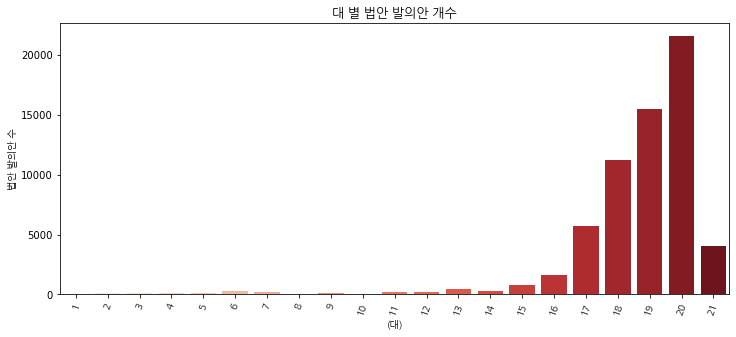

In [9]:
#대 별 법안 발의안 개수
fig = plt.figure(figsize=(12, 5))
sns.countplot(data = suggest, x = 'AGE', palette = 'Reds',
              hue_order = list(suggest['AGE'].value_counts().sort_values(ascending=False).index))
plt.title('대 별 법안 발의안 개수', fontproperties = font_title)
plt.xlabel('(대)', fontproperties = font_ticks)
plt.ylabel('법안 발의안 수', fontproperties = font_ticks)
plt.xticks(rotation = 70, fontproperties = font_ticks)

* 2004년 이후로 법안 발의안 수가 급격히 증가합니다.

## 1.2.법안 심사 소관위원회의 종류 변화

Text(0.5, 1.0, '대 별 소관위원회 수')

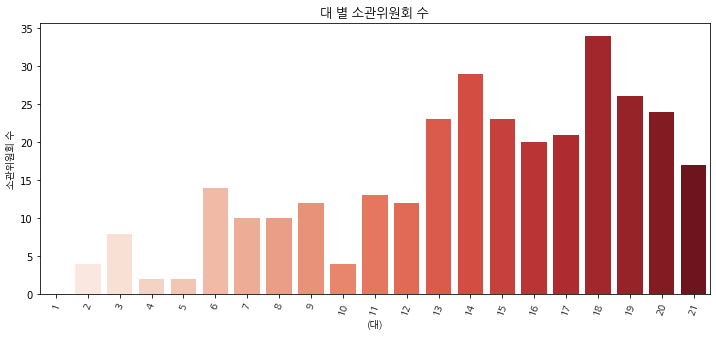

In [10]:
df = suggest.groupby('AGE')['COMMITTEE'].nunique().reset_index()

fig = plt.figure(figsize=(12, 5))
sns.barplot(data=df, x='AGE', y='COMMITTEE', palette = 'Reds')
plt.xlabel('(대)', fontproperties = font_ticks)
plt.xticks(rotation = 70, fontproperties = font_ticks)
plt.ylabel('소관위원회 수', fontproperties=font_ticks)
plt.title('대 별 소관위원회 수', fontproperties=font_title)

* 시간이 지남에 따라, 심사를 담당하는 소관위원회 종류도 점차 다양해지는 추세를 보입니다. 즉, 시간이 지남에 따라 점차 다양한 분야의 법안이 제안되고 있음을 알 수 있습니다.

현재 국회에 존재하는 소관위원회는 20개 입니다. 하지만 suggest 데이터는 1948년부터 축적되어 온 데이터이기 때문에, 현존하지 않는 소관위원회 이름을 다수 포함하고 있습니다. 따라서 과거 소관위원회 이름을 현존하는 이름으로 바꾸어 주는 작업을 수행하였습니다.

In [11]:
replace_dict = {'안전행정위원회':'행정안전위원회', '교육문화체육관광위원회':'문화체육관광위원회', 
 '행정자치위원회':'행정안전위원회', '상업통상자원위원회':'상업통상자원중소벤처기업위원회', 
 '건설교통위원회':'국토교통위원회', '교육과학기술위원회':'교육위원회',
 '미래창조과학방송통신위원회': '과학기술정보방송통신위원회', '재정경제위원회':'기획재정위원회',
 '문화체육관광방송통신위원회': '문화체육관광위원회',
 '농림수산식품위원회': '농림축산식품해양수산위원회',
 '지식경제위원회': '기획재정위원회',
 '문화관광위원회': '문화체육관광위원회',
 '농림해양수산위원회': '농림축산식품해양수산위원회',
 '산업자원위원회': '산업통상자원중소벤처기업위원회',
 '정치개혁특별위원회': '특별위원회',
 '내무위원회': '정무위원회',
 '과학기술정보통신위원회': '과학기술정보방송통신위원회',
 '재무위원회': '기획재정위원회',
 '보건사회위원회': '보건복지위원회',
 '외교통상통일위원회': '외교통일위원회',
 '통일외교통상위원회': '외교통일위원회',
 '문교공보위원회': '문화체육관광위원회',
 '보건복지가족위원회': '보건복지위원회',
 '농림위원회': '농림축산식품해양수산위원회',
 '상공위원회': '기획재정위원회',
 '규제개혁특별위원회': '특별위원회',
 '건설위원회': '국토교통위원회',
 '농수산위원회': '농림축산식품해양수산위원회',
 '정치개혁 특별위원회': '특별위원회',
 '아동·여성대상 성폭력 대책 특별위원회': '윤리특별위원회',
 '민주발전을위한법률개폐특별위원회': '특별위원회',
 '경제과학위원회': '기획재정위원회',
 '농림수산위원회': '농림축산식품해양수산위원회',
 '교통체신위원회': '국토교통위원회',
 '노동위원회': '환경노동위원회',
 '행정위원회': '행정안전위원회',
 '문화체육공보위원회': '문화체육관광위원회',
 '공항·발전소·액화천연가스인수기지주변대책특별위원회': '특별위원회',
 '교육체육청소년위원회': '교육위원회',
 '헌법개정 및 정치개혁 특별위원회': '특별위원회',
 '여성위원회': '여성가족위원회',
 '정치관계법심의특별위원회': '특별위원회',
 '문화공보위원회': '문화체육관광위원회',
 '통상산업위원회': '기획재정위원회',
 '공무원연금개혁 특별위원회': '특별위원회',
 '저출산고령화대책특별위원회': '특별위원회',
 '평창동계올림픽 및 국제경기대회지원특별위원회': '특별위원회',
 '동력자원위원회': '국토교통위원회',
 '방송통신특별위원회': '과학기술정보방송통신위원회',
 '국제경기대회지원특별위원회': '특별위원회',
 '문교체육위원회': '문화체육관광위원회',
 '세계박람회지원특별위원회': '특별위원회',
 '지방행정체제개편특별위원회': '특별위원회',
 '사법제도개혁특별위원회': '특별위원회',
 '상공자원위원회': '기획재정위원회',
 '외무통일위원회': '외교통일위원회',
 '과거사진상규명에관한특별위원회': '윤리특별위원회',
 '제24회서울올림픽대회지원특별위원회': '특별위원회',
 '재정제도개혁특별위원회': '특별위원회',
 '국제경기대회(세계육상선수권대회, 아시아경기대회, 포뮬러원국제자동차경주대회)지원특별위원회': '특별위원회',
 '통신과학기술위원회': '과학기술정보방송통신위원회',
 '통일외무위원회': '외교통일위원회',
 '정치개혁입법특별위원회': '특별위원회',
 '가축전염병예방법개정특별위원회': '특별위원회',
 '국제경기대회개최 및 유치지원특별위원회': '특별위원회',
 '기후변화대책특별위원회': '특별위원회',
 '행정경제위원회': '기획재정위원회',
 '2012년 여수세계박람회지원특별위원회': '특별위원회',
 '외무위원회': '외교통일위원회',
 '정당법및선거관계법개정법률심사특별위원회': '특별위원회',
 '5·18광주민주화운동특별위원회': '특별위원회',
 '특위': '특별위원회',
 '감찰위원회법안 기초특별위원회': '특별위원회',
 '체신과학기술위원회': '과학기술정보방송통신위원회',
 '지방자치특별위원회': '특별위원회',
 '정당법및선거관계법개정법률안심사특별위원회': '특별위원회',
 '국회법및국회상임위원회위원정수에관한규칙개정특별위원회': '특별위원회',
 '기후변화대응·녹색성장특별위원회': '특별위원회',
 '올림픽특별위원회': '특별위원회',
 '사회보건위원회': '보건복지위원회',
 '사법개혁 특별위원회': '특별위원회',
 '문교위원회': '문화체육관광위원회',
 '대전국제무역산업박람지원특별위원회': '특별위원회',
 '장애인에 대한 성폭력 등 인권침해 방지대책특별위원회': '윤리특별위원회',
 '산업통상자원위원회':'산업통상자원중소벤처기업위원회'}

In [12]:
suggest['committee_curr'] = suggest['COMMITTEE'].replace(replace_dict)
suggest['propose_year'] = suggest['PROPOSE_DT'].dt.year

## 1.3. 소관위원회 별 법안 발의안 심사 추이
1948년부터 현재까지 각 소관위원회가 심사한 법안의 수는 위와 같습니다. 시간의 흐름에 따라 소관위원회 별 법안 개수가 어떻게 변화하는지 살펴봄으로써, 시간의 흐름에 따라 어떤 분야의 법안이 많이 제안되는지 알 수 있을 것이고, 더 나아가 사회가 어떤 분야의 법을 필요로 하는지 알 수 있을 것입니다.

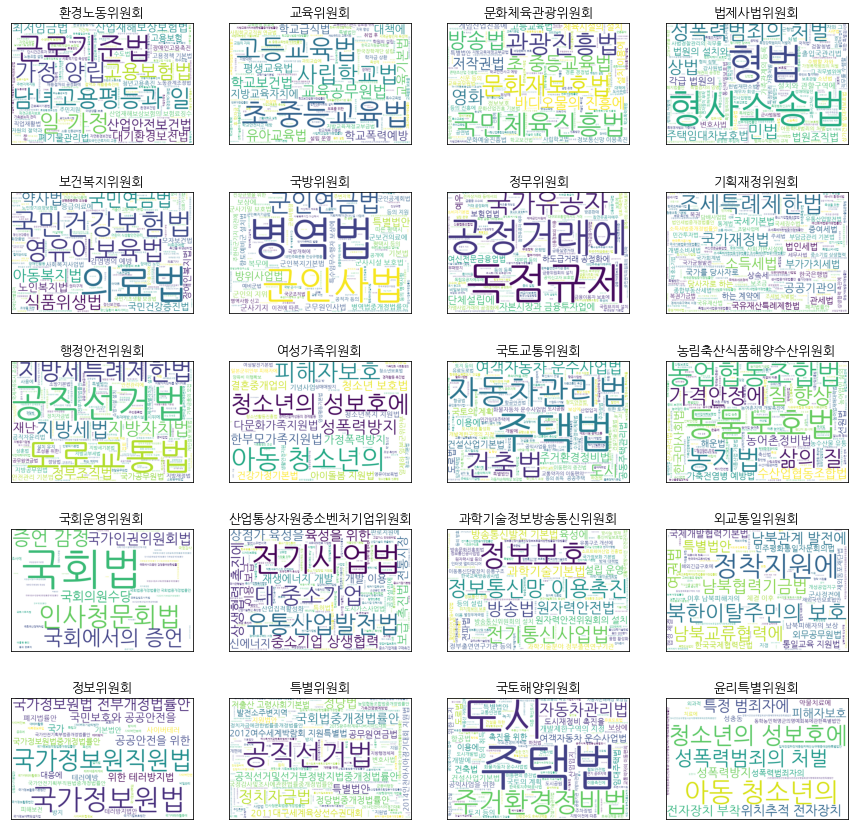

In [13]:
stopwords = set(STOPWORDS) 
stopwords.add('에')
stopwords.add('관한')
stopwords.add('일부개정법률안')
stopwords.add('법')
stopwords.add('대한')
stopwords.add(',')
stopwords.add('법률')
stopwords.add('법률안')
stopwords.add('등')
stopwords.add('및')
stopwords.add('등에')
stopwords.add('지원에')
stopwords.add('관리에')
stopwords.add('운영에')
stopwords.add('처리에')
stopwords.add('특별법')
stopwords.add('특별조치법')
stopwords.add('특례법')
fig = plt.figure(figsize = (15,15))
i = 1
for committee in list(suggest['committee_curr'].unique())[1:]:
    name = ','.join(suggest.loc[suggest.committee_curr == committee, 'BILL_NAME'])
    wc = WordCloud(background_color='white',
                font_path = font_path,
                width=600,
                height=400,
                stopwords=stopwords).generate(name)
    plt.subplot(5,4,i)
    plt.imshow(wc)
    plt.xticks([])
    plt.yticks([])
    plt.title(committee, fontproperties = font_title)
    i += 1
    

위 워드클라우드를 통해 각 소관위원회가 어떤 의안을 심사하는지 파악할 수 있습니다.

In [14]:
committee_curr = suggest.groupby(['propose_year','committee_curr']).size().reset_index()
committee_curr.columns = ['year', 'COMMITTEE', 'COUNT']
committee_curr['norm_count'] = committee_curr.groupby('year')['COUNT'].apply(lambda x: x/sum(x))

우선 각 소관위원회 별로 심사한 법안의 개수가 시간의 흐름에 따라 어떻게 변화하는지 보겠습니다.

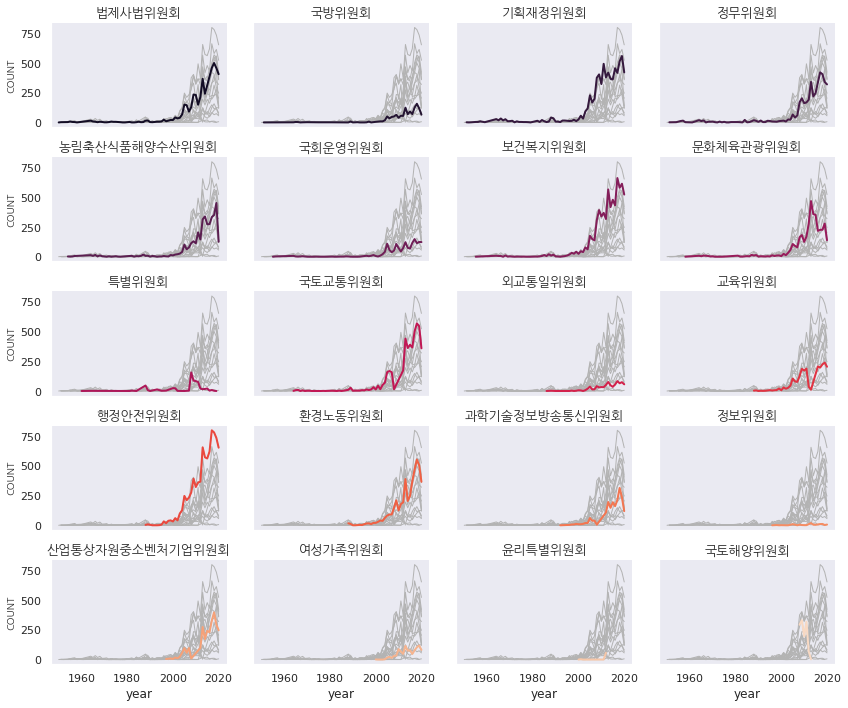

In [15]:
sns.set(style = 'dark')
g = sns.relplot(
    data=committee_curr,
    x="year", y="COUNT", col="COMMITTEE", hue="COMMITTEE",
   kind="line", linewidth=2, zorder=5, palette = 'rocket',
    col_wrap=4, height=2, aspect=1.5, legend=False,
)

i = 0
committees = list(committee_curr['COMMITTEE'].unique())

for ax in g.axes:
    ax.set_title(committees[i], fontproperties=font_title)
    ax.set_ylabel('제안된 법안 개수', fontproperties=font_ticks)
    sns.lineplot(
        data=committee_curr, x="year", y="COUNT", units="COMMITTEE",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )
    i += 1

* 전반적으로 모든 소관위원회에서 심사한 법안의 개수는 증가하는 추세입니다.
* 보건복지위원회, 행정안전위원회, 환경노동위원회 관련 의안의 증가율이 높습니다.
* 국방위원회, 국회운영위원회, 외교통일위원회, 정보위원회 관련 의안의 증가율이 낮습니다.
* 정보위원회, 산업통상자원중소벤처기업위원회, 여성가족위원회 등은 2000년대 이후 최근부터 의안을 심사했습니다.

이번에는, 각 연도별로 연도별 소관위원회 비중(= 해당 연도 특정 소관위원회 심사 법안 개수 / 해당 연도 심사 법안 개수)를 계산한 뒤, 시각화 해 보겠습니다. 

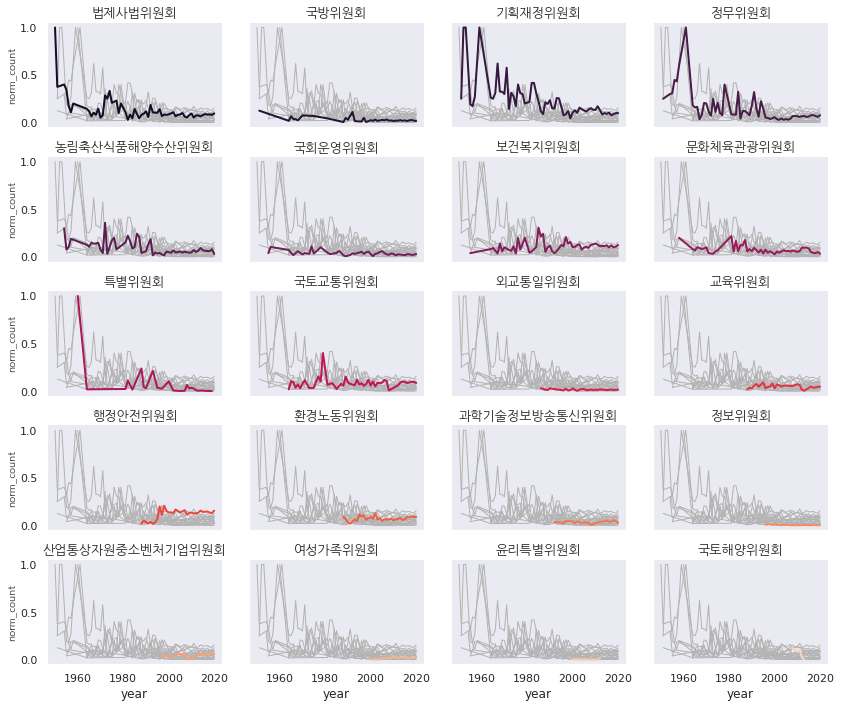

In [16]:
sns.set(style = 'dark')
g = sns.relplot(
    data=committee_curr,
    x="year", y="norm_count", col="COMMITTEE", hue="COMMITTEE",
    kind="line", linewidth=2, zorder=5, palette = 'rocket',
    col_wrap=4, height=2, aspect=1.5, legend=False,
)

i = 0
committees = list(committee_curr['COMMITTEE'].unique())

for ax in g.axes:
    ax.set_title(committees[i], fontproperties=font_title)
    ax.set_ylabel('제안된 법안 개수 비율', fontproperties = font_ticks)
    sns.lineplot(
        data=committee_curr, x="year", y="norm_count", units="COMMITTEE",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )
    i += 1


시간이 지남에 따라 법안을 심사한 소관위원회 수가 증가하기 때문에, 시간이 지남에 따라 각 소관위원회의 비중은 줄어들게 됨을 확인할 수 있습니다.

* 법제사법위원회 정무위원회는 과거에 비해 심사, 비중이 낮아지고 있습니다.
* 교육위원회, 보건복지위원회, 행정안전위원회, 문화체육관광위원회, 환경노동위원회는 초기에 비해 심사 비중이 높아지고 있습니다.
* 기획재정위원회는 과거부터 현재까지 꾸준히 높은 심사 비중을 보여줍니다.

## 1.4. wordcloud를 통한 법안발의 분야 시각화

지금부턴 각 10년 단위로 어떤 소관위원회의 심사 비중이 높았는지 파악하기 위해, word cloud를 만들어 보겠습니다.

In [17]:
suggest['decade'] = np.trunc(suggest.propose_year/10)*10

In [18]:
c = suggest.groupby(['decade','committee_curr']).size()
c = c.reset_index()
c.columns = ['decade','committee', 'count']
for i in range(c.shape[0]):
    c.loc[i, 'committee'] = c.loc[i,'committee'][:-3]

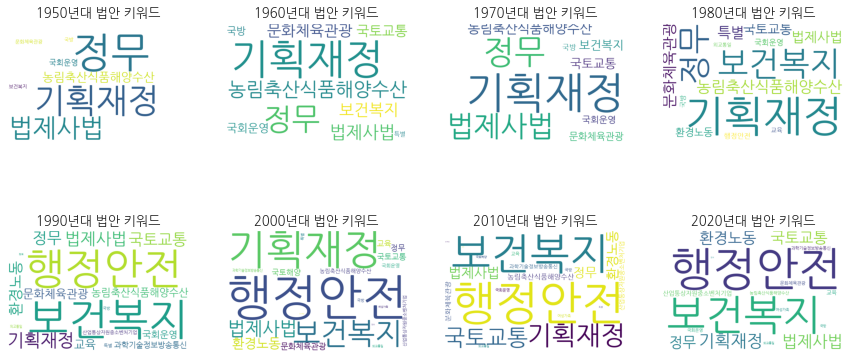

In [19]:
fig, ax = plt.subplots(2, 4, figsize = (15,7))
i = 1
for decade in range(1950, 2030, 10):
    df = c[c.decade == decade]
    freq = list(zip(list(df['committee']), list(df['count'])))
    wc = WordCloud( background_color='white',
                        font_path = font_path,
                        width=600,
                        height=400).generate_from_frequencies(dict(freq))
    plt.subplot(2,4,i)
    plt.imshow(wc)
    plt.xticks([])
    plt.yticks([])
    plt.title(str(decade)+'년대 법안 키워드', fontproperties = font_title)
    i += 1
    

# 2. 제안된 법안의 처리 과정 및 결과
제안된 법안은 여러 심사 단계를 거쳐 최종적으로 '폐기', '철회', '수정가결', '원안가결', '부결', '비상국무회의로이관' 의 여섯가지 결과에 이릅니다.

* 원안가결 : 제안된 법안이 그대로 본회의 심사를 통과한 경우
* 수정가결 : 제안된 법안이 수정되어 본회의 심사를 통과한 경우
* 부결 : 제안된 법안이 본회의 심사에서 가결되지 않아 법안으로 채택되지 않은 경우
* 철회 : 제안된 법안이 제안자에 의해 철회된 경우
* 폐기 : 제안된 법안이 소관위원회 심사 혹은 법사위체계자구 심사를 통과하지 못하여 본회의 심사에도 회부되지 못한 경우 
* 비상국무회의로이관 : 유신정권에서 국회의 역할을 비상국무회의가 대체함

## 2.1. 제안된 법안의 처리 결과

In [20]:
suggest['PROC_RESULT_1'] = suggest['PROC_RESULT'].replace({'대안반영폐기':'폐기',
                                                           '임기만료폐기':'폐기',
                                                           '수정안반영폐기':'폐기',
                                                           '회기불계속폐기':'폐기'})

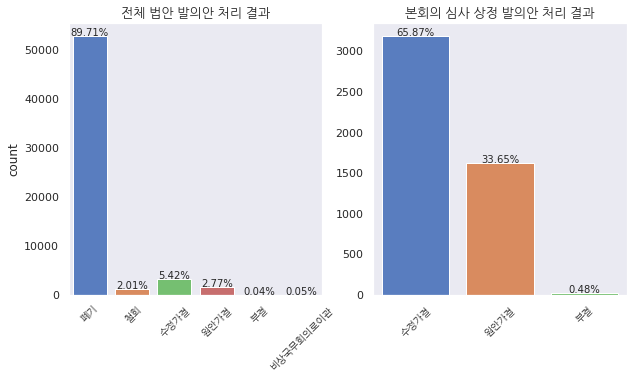

In [21]:
fig = plt.figure(figsize = (10, 5))

plt.subplot(1,2,1)
g = sns.countplot(data = suggest, x = 'PROC_RESULT_1', palette = 'muted')
plt.xticks(rotation = 45, fontproperties = font_ticks)
plt.title('전체 법안 발의안 처리 결과', fontproperties = font_title)
plt.xlabel('')
total_amt = suggest[suggest.PROC_RESULT.notnull()==True].shape[0]
for bar in g.patches:
    height = bar.get_height()
    g.text(bar.get_x()+bar.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=10) 
    
suggest_1 = suggest[(suggest.PROC_RESULT_1 != '폐기')&(suggest.PROC_RESULT_1 != '철회')&(suggest.PROC_RESULT_1 != '비상국무회의로이관')&(suggest.PROC_RESULT_1.notnull()==True)]
plt.subplot(1,2,2)
g1 = sns.countplot(data = suggest_1, x = 'PROC_RESULT_1', palette = 'muted')
plt.xticks(rotation = 45, fontproperties = font_ticks)
plt.title('본회의 심사 상정 발의안 처리 결과', fontproperties = font_title)
plt.ylabel('')
plt.xlabel('')
total_amt = suggest_1.shape[0]
for bar in g1.patches:
    height = bar.get_height()
    g1.text(bar.get_x()+bar.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=10) 

제안된 법안의 90%는 본회의 심사에 회부되기도 전에 폐기됩니다. 전체 법안 중 8% 정도만이 가결되어 최종적인 법안으로 승인됨을 확인할 수 있습니다. 또한 본회의 심사에 회부된 법안은 대부분 법으로 채택되고 극히 일부(0.48%)만이 부결됨을 확인할 수 있습니다. 다음으로는, 대 별로 처리결과 비율이 어떻게 변화하는지 확인해 보겠습니다.

In [22]:
df = suggest.groupby(['AGE', 'PROC_RESULT_1']).size()
df = df.dropna(axis = 0)
df = df.reset_index()
df.columns = ['AGE', 'PROC_RESULT', 'COUNT']

df['CUM_COUNT'] = df.groupby('AGE')['COUNT'].cumsum(axis = 0)
df['NORM_COUNT'] = df.groupby('AGE')['COUNT'].apply(lambda x: x / sum(x))
df['CUM_NORM_COUNT'] = df.groupby('AGE')['NORM_COUNT'].cumsum(axis = 0)
df = df.sort_values(by=['CUM_NORM_COUNT'], ascending = False)

Text(0.5, 1.0, '대 별 법안 발의안 처리 결과 비율')

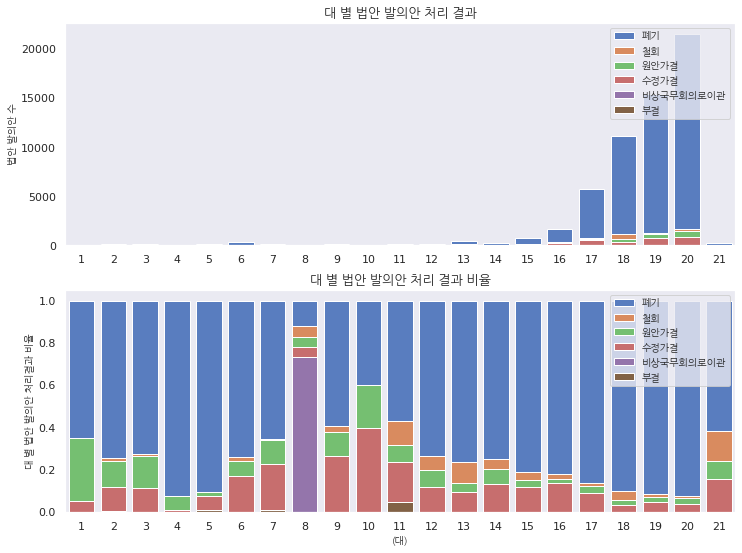

In [23]:
fig = plt.figure(figsize = (12, 9))
plt.subplot(2,1,1)
sns.barplot(x='AGE', y='CUM_COUNT', hue = 'PROC_RESULT', data = df, dodge = False, palette = 'muted')
plt.legend(prop = font_ticks)
plt.xlabel('')
plt.ylabel('법안 발의안 수', fontproperties = font_ticks)
plt.title('대 별 법안 발의안 처리 결과', fontproperties = font_title)

plt.subplot(2,1,2)
sns.barplot(x='AGE', y='CUM_NORM_COUNT', hue = 'PROC_RESULT', data = df, dodge = False, palette = 'muted')
plt.legend(prop = font_ticks)
plt.xlabel('(대)', fontproperties = font_ticks)
plt.ylabel('대 별 법안 발의안 처리결과 비율', fontproperties = font_ticks)
plt.title('대 별 법안 발의안 처리 결과 비율', fontproperties = font_title)

* 15대 이후로 의안 갯수가 매우 큰 폭으로 증가합니다.
* 반면 의안 폐기율은 10대 국회 이후로 꾸준히 증가하는 양상을 보입니다.

국회의원의 평가 지표 중 하나가 '의안 제안 수'라고 합니다. 이러한 평가 지표 때문에 지나치게 많은 의안이 제안되고, 그만큼 많은 의안이 폐기되어 국회의 효율성이 떨어진다고 판단 할 수 있습니다.

이번엔 법안 분야별로, 처리 결과에 차이가 있는지에 대해서도 확인해 보겠습니다. 법안의 분야는 심사를 담당한 소관위원회로 판단하겠습니다.

In [24]:
df = suggest.groupby(['committee_curr', 'PROC_RESULT_1']).size().reset_index()
df = df.rename(columns = {0 : 'count'})
sum = df.groupby('committee_curr')['count'].sum()
pass_ratio = []
comm = list(df['committee_curr'].unique())
i = 0
for com in comm:
    df_1 = df[df.committee_curr == com]
    pass_ratio.append(df_1.loc[(df.PROC_RESULT_1 == '수정가결')|(df.PROC_RESULT_1 == '원안가결'), 'count'].sum() / sum[i])
    i += 1
df_pass = sum.reset_index()
df_pass['ratio'] = np.array(pass_ratio)
df_pass_all = df_pass.copy()
df_pass_all = df_pass_all.rename(columns = {'count': 'count_all', 'ratio':'ratio_all'})

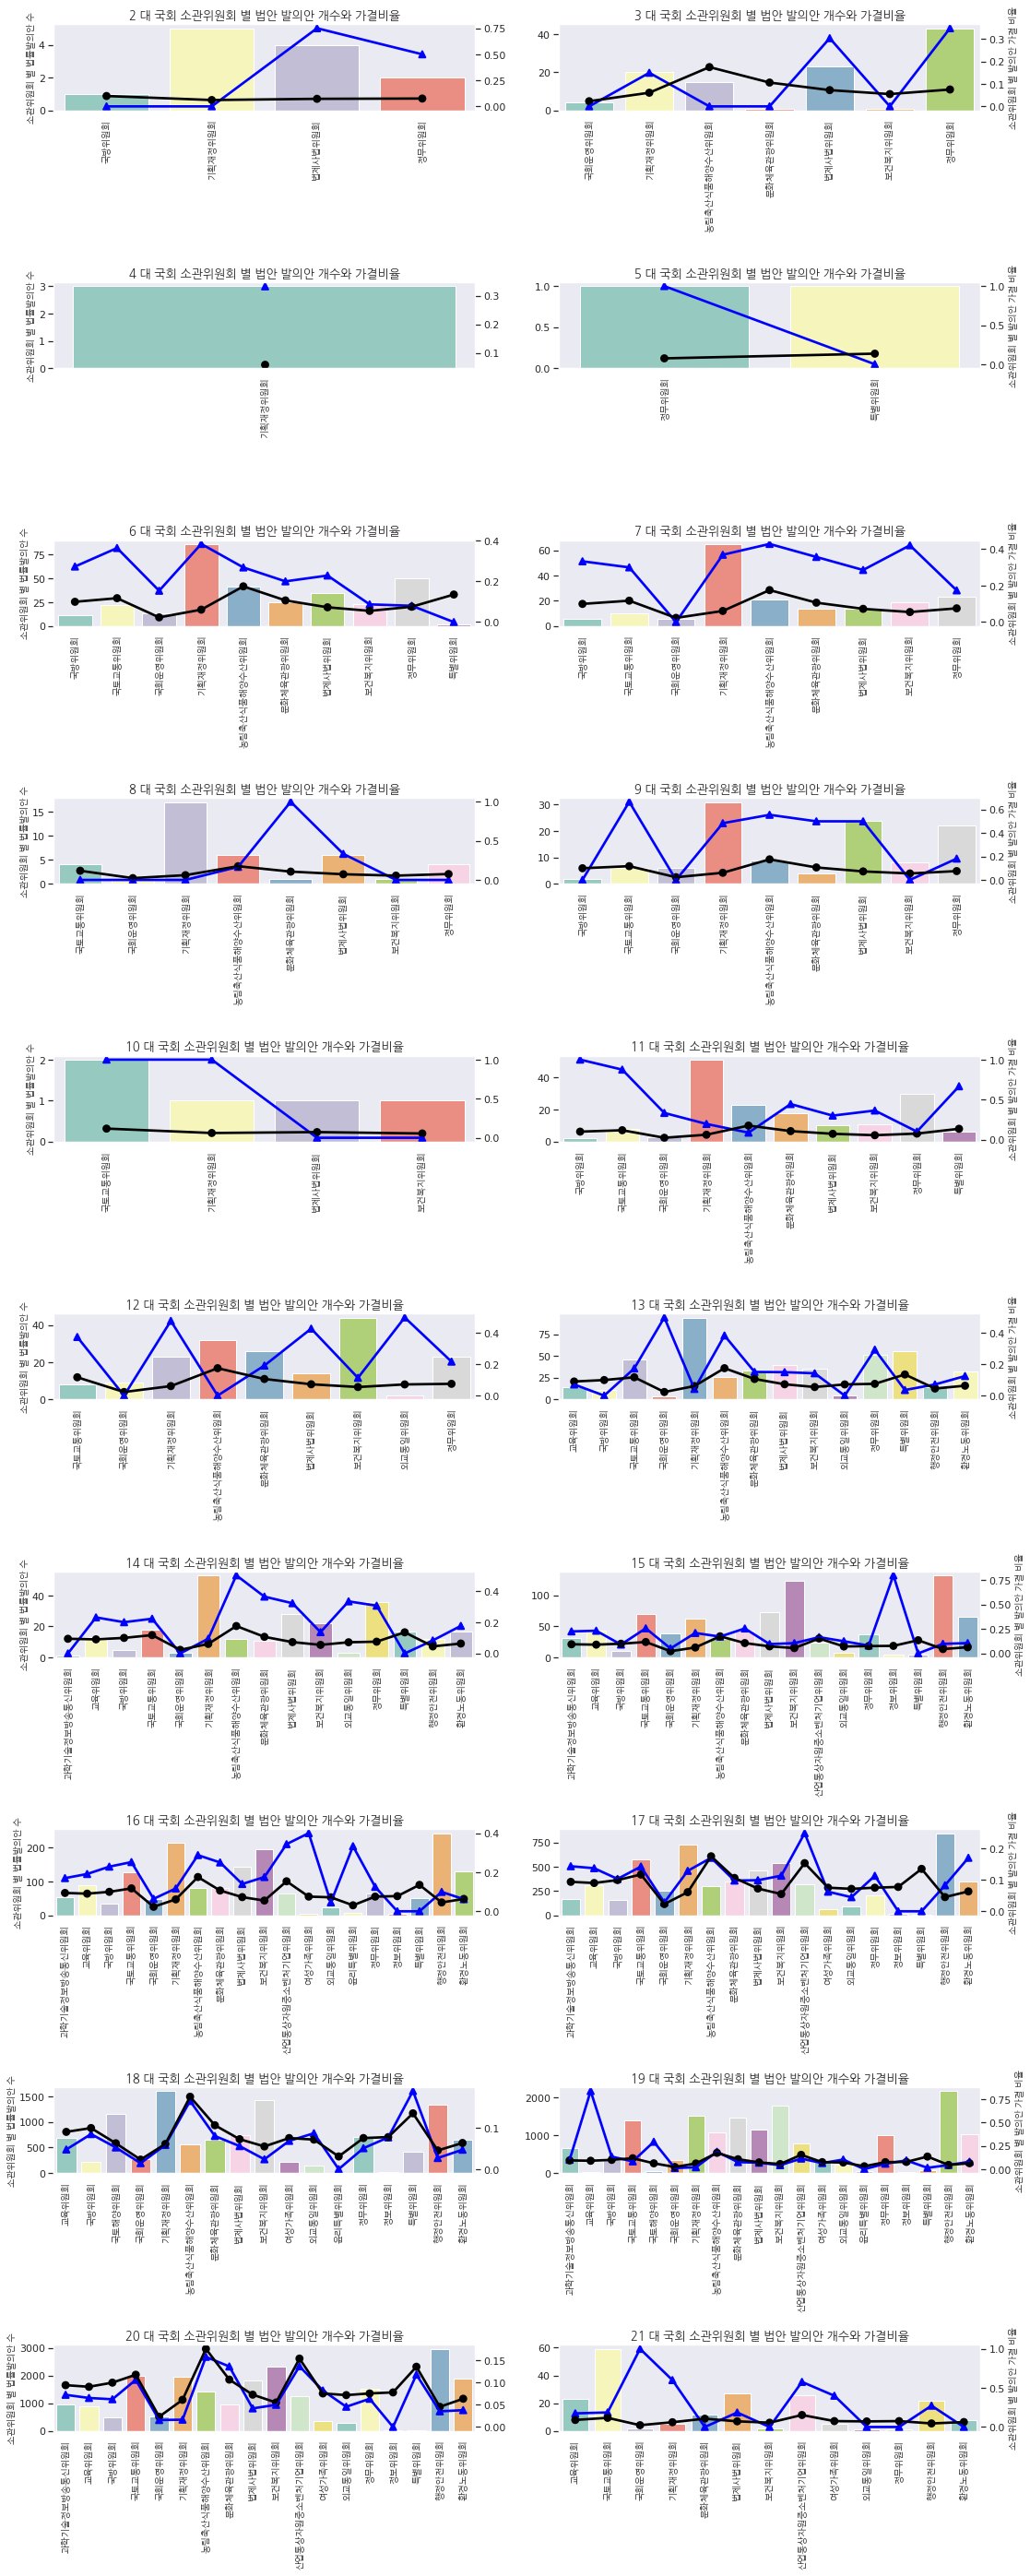

In [25]:
#대 별 소관위원회 별 최종 가결률
k = 1
fig, ax = plt.subplots(10,2, figsize = (18, 48))

for age in range(2,22):
    suggest_age = suggest[suggest.AGE == age]
    df = suggest_age.groupby(['committee_curr', 'PROC_RESULT_1']).size().reset_index()
    df = df.rename(columns = {0 : 'count'})
    sum = df.groupby('committee_curr')['count'].sum()
    pass_ratio = []
    comm = list(df['committee_curr'].unique())
    i = 0
    for com in comm:
        df_1 = df[df.committee_curr == com]
        pass_ratio.append(df_1.loc[(df.PROC_RESULT_1 == '수정가결')|(df.PROC_RESULT_1 == '원안가결'), 'count'].sum() / sum[i])
        i += 1
    df_pass = sum.reset_index()
    df_pass['ratio'] = np.array(pass_ratio)
    df_pass = df_pass.merge(df_pass_all, on = 'committee_curr', how = 'left')
    
    plt.subplot(10,2,k)
    g1 = sns.barplot(data=df_pass, x = 'committee_curr', y ='count', palette = 'Set3')
    g1.set_xlabel('')
    plt.xticks(rotation = 90, fontproperties = font_ticks)
    g2 = g1.twinx()
    g2 = sns.pointplot(data = df_pass, x='committee_curr', y = 'ratio', color = 'blue', markers = '^', linestyle = '--')
    g3 = sns.pointplot(data = df_pass, x='committee_curr', y = 'ratio_all', color = 'black')
    if k % 2 == 1:
        g1.set_ylabel('소관위원회 별 법률발의안 수', fontproperties = font_ticks)
        g2.set_ylabel('')
    else:
        g1.set_ylabel('')
        g2.set_ylabel('소관위원회 별 발의안 가결 비율', fontproperties = font_ticks)
    plt.title('{} 대 국회 소관위원회 별 법안 발의안 개수와 가결비율'.format(age), fontproperties = font_title)
    k += 1
    
plt.subplots_adjust(hspace = 2)


위 차트에서 검은색 pointplot은 각 소관위원회 별 전체 평균 가결률을 나타내고, 파란색 pointplot은 해당 '대'의 소관위원회 별 평균 가결율을 나타냅니다. 
* 16대 국회까지는 많은 분야의 의안이 전체 평균 가결율에 비해 비교적 높은 가결율을 보여주는데 반해, 17대 국회부터는 많은 분야의 의안이 비교적 낮은 가결율을 보여줍니다.
* 최근 21대 국회는 전년과 조금 다른 양상을 보이는데, 국회운영.기획재정.산업통상중소벤처기업.여성가족.행정안전 관련 의안에서 높은 가결율이 나타납니다.

## 2.2. 법안의 처리 과정과 날짜
다시 한 번 언급하자면, 법안발의안에 대한 처리 과정은
* 1. 국회의원의 법안 제안
* 2. 법안과 관련된 분야의 소관위원회 심사(해당 분야의 실정과 제안된 법안이 맞는지에 대한 심사)
* 3. 법사위체계자구심사(제안된 법안이 법리와 상충하지 않는지에 대한 심사 및 보완)
* 4. 본회의 심사
* 5. 본회의 심사 통과 법안 정부이송
* 6. 국무회의 상정 및 법안 공포

위 6단계로 이루어지며, process data에는 *소관위원회심사, 법사위체계자구심사, 본회의심사* 에 대한 날짜 정보가 수록되어 있습니다. 또한 각 심사는 '회부'->'상정'->'의결' 의 순서로 이루어집니다.

In [26]:
#suggest data와 process data에 공통으로 있는 법안을 대상으로만 분석 진행
legis = process.merge(suggest, on = 'BILL_ID', how = 'left', suffixes = ["_drop",""])
legis = legis[legis.BILL_ID.isin(suggest['BILL_ID'].unique())]
legis = legis.drop(['AGE_drop', 'BILL_NAME_drop', 'BILL_NO_drop','PROPOSER_drop','PROPOSE_DT_drop'], axis = 1)
legis = legis.reset_index().drop('index', axis = 1)

In [27]:
#legis data에 있는 date feature들을 datetime 자료형으로 바꾸어주기
dt_col = legis.columns[legis.columns.str.endswith('DT')]
for col in dt_col:
    legis[col] = pd.to_datetime(legis[col], errors = 'coerce')

법안의 처리 과정에 대한 분석을 진행하기 위하여 process data와 suggest data를 merge한 뒤, 두 데이터에 공통으로 존재하는 법안만 필터링하여 legis 라는 새로운 데이터셋을 만들었습니다. 

### 2.2.1. 소관위원회 심사 날짜
많은 수의 의안과 높은 의안 폐기율로 비효율적이라고 판단했던 20대 국회의 심사 날짜 분포를 확인해 보겠습니다.
우선 소관위원회 심사일자 분포를 확인해 보겠습니다.

In [28]:
committee = legis.loc[legis.AGE==20,['COMMITTEE_SUBMIT_DT','COMMITTEE_PRESENT_DT', 'COMMITTEE_PROC_DT']]
#요일
committee['submit_weekday'] = committee.COMMITTEE_SUBMIT_DT.dt.day_name()
committee['present_weekday'] = committee.COMMITTEE_PRESENT_DT.dt.day_name()
committee['proc_weekday'] = committee.COMMITTEE_PROC_DT.dt.day_name()
#월
committee['submit_month'] = committee.COMMITTEE_SUBMIT_DT.dt.month
committee['present_month'] = committee.COMMITTEE_PRESENT_DT.dt.month
committee['proc_month'] = committee.COMMITTEE_PROC_DT.dt.month

Text(0, 0.5, '')

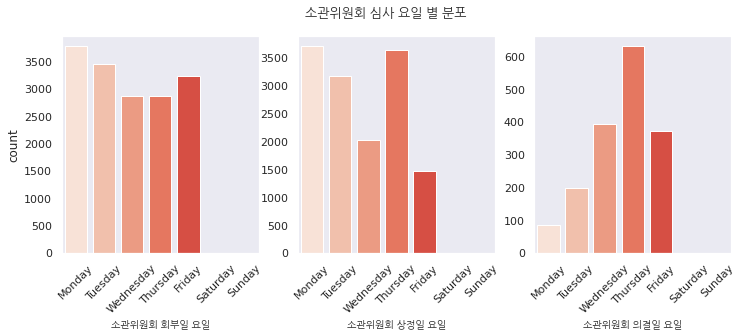

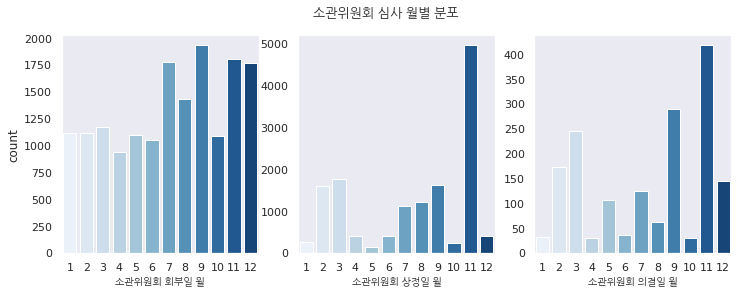

In [29]:
#소관위원회 심사 요일
plt.figure(figsize = (12, 4))
plt.suptitle('소관위원회 심사 요일 별 분포', fontproperties = font_title)
plt.subplot(1,3,1)
sns.countplot(data = committee, x = 'submit_weekday',palette = 'Reds',
              order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xticks(rotation = 45)
plt.xlabel('소관위원회 회부일 요일', fontproperties = font_ticks)
plt.subplot(1,3,2)
sns.countplot(data = committee, x = 'present_weekday',palette = 'Reds',
             order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xticks(rotation = 45)
plt.xlabel('소관위원회 상정일 요일', fontproperties = font_ticks)
plt.ylabel('')
plt.subplot(1,3,3)
sns.countplot(data = committee, x = 'proc_weekday',palette = 'Reds',
             order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xticks(rotation = 45)
plt.xlabel('소관위원회 의결일 요일', fontproperties = font_ticks)
plt.ylabel('')

#소관위원회 심사 월
plt.figure(figsize=(12,4))
plt.suptitle('소관위원회 심사 월별 분포', fontproperties = font_title)
plt.subplot(1,3,1)
sns.countplot(data = committee, x = 'submit_month',palette = 'Blues',
              order = list(np.arange(1,13,1)))
plt.xlabel('소관위원회 회부일 월', fontproperties = font_ticks)
plt.subplot(1,3,2)
sns.countplot(data = committee, x = 'present_month',palette = 'Blues',
             order = list(np.arange(1,13,1)))
plt.xlabel('소관위원회 상정일 월', fontproperties = font_ticks)
plt.ylabel('')
plt.subplot(1,3,3)
sns.countplot(data = committee, x = 'proc_month',palette = 'Blues',
             order = list(np.arange(1,13,1)))
plt.xlabel('소관위원회 의결일 월', fontproperties = font_ticks)
plt.ylabel('')

* 요일 별 분포에서는 눈에 띄는 패턴이 발견되지 않습니다.
* 월별 분포를 보면 소관위원회 회부는 비교적 고른 분포를 보이는 반면, 소관위원회 상정이 11월에 집중되어 있고, 소관위원회 의결은 11월과 12월에 집중되어 있는 양상이 보입니다. 1월을 제외한 연말과 연초에 대부분의 소관위원회 소집 및 심사가 수행됨을 알 수 있습니다. 앞에서 언급한 국회의 비효율화와 연결지어 생각하자면, 지나치게 많은 의안으로 인해 벼락치기식 심사가 수행된다고 이해할 수도 있습니다.

### 2.2.2. 법제자구체계위원회 심사 날짜
다음으로, 법제자구체계위원회 심사 날짜를 시각화 해 보겠습니다. 

In [30]:
law = legis.loc[legis.AGE == 20, ['LAW_SUBMIT_DT','LAW_PRESENT_DT', 'LAW_PROC_DT']]
#요일
law['submit_weekday'] = law.LAW_SUBMIT_DT.dt.day_name()
law['present_weekday'] = law.LAW_PRESENT_DT.dt.day_name()
law['proc_weekday'] = law.LAW_PROC_DT.dt.day_name()
#월
law['submit_month'] = law.LAW_SUBMIT_DT.dt.month
law['present_month'] = law.LAW_PRESENT_DT.dt.month
law['proc_month'] = law.LAW_PROC_DT.dt.month

Text(0, 0.5, '')

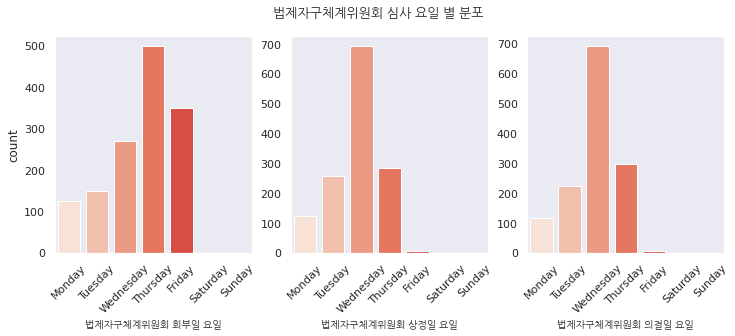

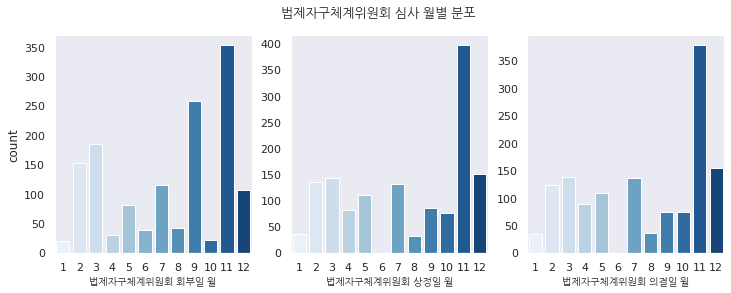

In [31]:
plt.figure(figsize = (12, 4))
plt.suptitle('법제자구체계위원회 심사 요일 별 분포', fontproperties = font_title)
plt.subplot(1,3,1)
sns.countplot(data = law, x = 'submit_weekday',palette = 'Reds',
              order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xticks(rotation = 45)
plt.xlabel('법제자구체계위원회 회부일 요일', fontproperties = font_ticks)
plt.subplot(1,3,2)
sns.countplot(data = law, x = 'present_weekday',palette = 'Reds',
             order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xticks(rotation = 45)
plt.xlabel('법제자구체계위원회 상정일 요일', fontproperties = font_ticks)
plt.ylabel('')
plt.subplot(1,3,3)
sns.countplot(data = law, x = 'proc_weekday',palette = 'Reds',
             order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xticks(rotation = 45)
plt.xlabel('법제자구체계위원회 의결일 요일', fontproperties = font_ticks)
plt.ylabel('')

#소관위원회 심사 월
plt.figure(figsize=(12,4))
plt.suptitle('법제자구체계위원회 심사 월별 분포', fontproperties = font_title)
plt.subplot(1,3,1)
sns.countplot(data = law, x = 'submit_month',palette = 'Blues',
              order = list(np.arange(1,13,1)))
plt.xlabel('법제자구체계위원회 회부일 월', fontproperties = font_ticks)
plt.subplot(1,3,2)
sns.countplot(data = law, x = 'present_month',palette = 'Blues',
             order = list(np.arange(1,13,1)))
plt.xlabel('법제자구체계위원회 상정일 월', fontproperties = font_ticks)
plt.ylabel('')
plt.subplot(1,3,3)
sns.countplot(data = law, x = 'proc_month',palette = 'Blues',
             order = list(np.arange(1,13,1)))
plt.xlabel('법제자구체계위원회 의결일 월', fontproperties = font_ticks)
plt.ylabel('')

* 법제자구체계위원회 심사가 높은 비율로 수요일에 진행됩니다.
* 소관위원회심사와 마찬가지로 위원회 소집과 의결이 연말과 1월을 제외한 연초에 진행되고, 특정 달에 몰린 소위 벼락치기식 운영의 양상을 보입니다.

### 2.2.3. 본회의 심사 날짜
마지막으로, 본회의 심사 날짜에 대해 시각화 해 보겠습니다.

In [32]:
rgs = legis.loc[legis.AGE == 20, ['RGS_PRESENT_DT', 'RGS_PROC_DT']]
#요일
rgs['present_weekday'] = rgs.RGS_PRESENT_DT.dt.day_name()
rgs['proc_weekday'] = rgs.RGS_PROC_DT.dt.day_name()
#월
rgs['present_month'] = rgs.RGS_PRESENT_DT.dt.month
rgs['proc_month'] = rgs.RGS_PROC_DT.dt.month

Text(0, 0.5, '')

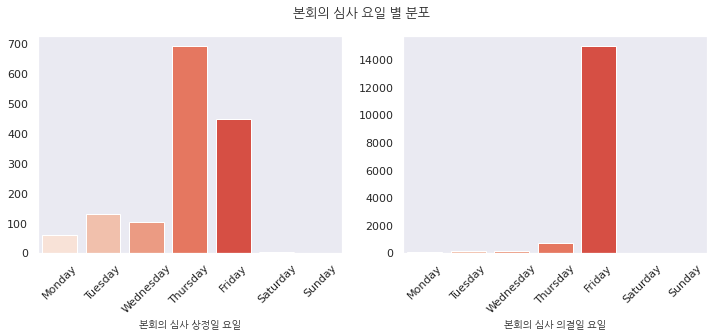

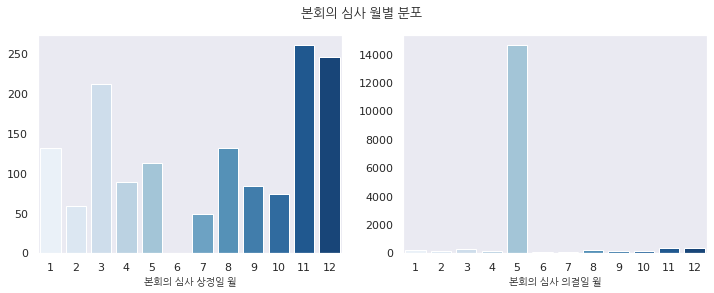

In [33]:
plt.figure(figsize = (12, 4))
plt.suptitle('본회의 심사 요일 별 분포', fontproperties = font_title)
plt.subplot(1,2,1)
sns.countplot(data = rgs, x = 'present_weekday',palette = 'Reds',
             order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xticks(rotation = 45)
plt.xlabel('본회의 심사 상정일 요일', fontproperties = font_ticks)
plt.ylabel('')
plt.subplot(1,2,2)
sns.countplot(data = rgs, x = 'proc_weekday',palette = 'Reds',
             order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xticks(rotation = 45)
plt.xlabel('본회의 심사 의결일 요일', fontproperties = font_ticks)
plt.ylabel('')

#소관위원회 심사 월
plt.figure(figsize=(12, 4))
plt.suptitle('본회의 심사 월별 분포', fontproperties = font_title)
plt.subplot(1,2,1)
sns.countplot(data = rgs, x = 'present_month',palette = 'Blues',
             order = list(np.arange(1,13,1)))
plt.xlabel('본회의 심사 상정일 월', fontproperties = font_ticks)
plt.ylabel('')
plt.subplot(1,2,2)
sns.countplot(data = rgs, x = 'proc_month',palette = 'Blues',
             order = list(np.arange(1,13,1)))
plt.xlabel('본회의 심사 의결일 월', fontproperties = font_ticks)
plt.ylabel('')

본회의 심사 회부일은 데이터에 포함되어 있지 않은 관계로 상정일과 의결일에 대해서만 분석 해 보겠습니다.
* 한가지 눈여겨볼 점이 있다면, 의결의 대부분이 5월에 발생한다는 점입니다.

### 2.2.4. 정부이송일과 공포일

In [34]:
trans_anno = legis[['CURR_TRANS_DT', 'ANNOUNCE_DT']]
trans_anno['trans_month'] = trans_anno['CURR_TRANS_DT'].dt.month
trans_anno['anno_month'] = trans_anno['ANNOUNCE_DT'].dt.month

Text(0.5, 0, '공포일')

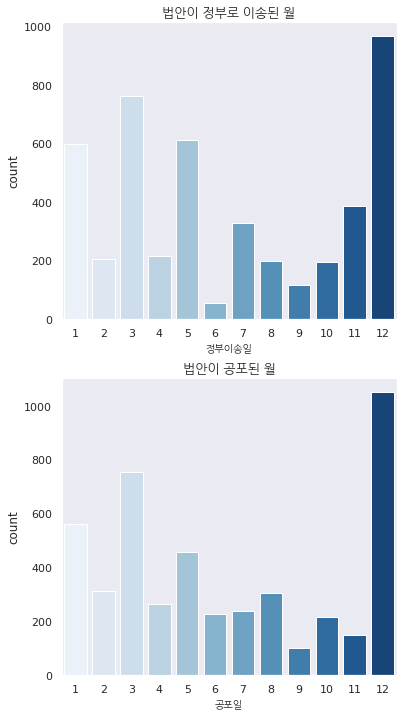

In [35]:
plt.figure(figsize = (6,12))

plt.subplot(2,1,1)
sns.countplot(data=trans_anno, x='trans_month', palette = 'Blues', order = list(np.arange(1,13,1)))
plt.title('법안이 정부로 이송된 월', fontproperties = font_title)
plt.xlabel('정부이송일', fontproperties = font_ticks)

plt.subplot(2,1,2)
sns.countplot(data=trans_anno, x='anno_month', palette = 'Blues', order = list(np.arange(1,13,1)))
plt.title('법안이 공포된 월', fontproperties = font_title)
plt.xlabel('공포일', fontproperties = font_ticks)

## 데이터를 통해 본 20대 국회의 의안 처리과정과 날짜 패턴 Summary
* 1. 법안발의안이 1월~12월에 걸쳐 제안되면 11월에 소관위원회가 상정됩니다.
* 2. 11월에 상정된 소관위원회가 12월에 심사 결과를 발표(의결)합니다.
* 3. 12월에 소관위원회가 의결을 마치면, 법제자구체계위원회에서 법리를 검토한 뒤 동월에 법안에 대한 의결을 마칩니다.
* 4. 12월에 법제자구체계위원회에서 법리 검토를 마치면, 동월에 본회의 심사에 상정됩니다.
* 5. 본회의 심사에 상정된 모든 법안은 다음 해 5월에 국회의원의 투표를 통해 한번에 의결됩니다.  

## 데이터를 통해 본 20대 국회의 문제점
* 1. 의안이 너무 많고, 이에 따라 폐기되는 법안도 너무 많이 발생합니다.
* 2. 의안이 너무 많다 보니, 날짜 패턴에서 보았듯이 심사가 벼락치기식으로 운영되는 경향이 보이고, 이에 따라 질 높은 심사가 이루어지지 못할 가능성도 높아진다고 생각합니다.

# 3. 국회는 개선되고 있는가?
의안 개수, 가결율, 국회의원의 구성 등의 측면에서 20대 국회와 21대 국회를 비교해 보겠습니다.

## 3.1. 의안 개수와 가결율
21대 국회는 출범한 지 6개월 밖에 되지 않았으며, 첫 PROPOSE_DT는 2020년 6월1일 이므로(2020.10.05일까지의 데이터만 존재하므로), 20대 동기와 비교 하겠습니다.

In [36]:
suggest[suggest.AGE==21].PROPOSE_DT.min()

Timestamp('2020-06-01 00:00:00')

In [37]:
#국회 출범일로부터 4개월 간의 기간으로 필터링
suggest_21 = suggest[suggest.AGE==21]
suggest_20 = suggest[(suggest.PROPOSE_DT>pd.to_datetime('2016-05-30'))&(suggest.PROPOSE_DT<pd.to_datetime('2016-09-30'))]

In [38]:
suggest_20_pass = suggest_20[(suggest_20['PROC_RESULT'] == '수정가결')|(suggest_20['PROC_RESULT']=='원안가결')]
suggest_21_pass = suggest_21[(suggest_21['PROC_RESULT'] == '수정가결')|(suggest_21['PROC_RESULT']=='원안가결')]

In [39]:
df = pd.DataFrame({'AGE':[20,21], 'count':[len(suggest_20), len(suggest_21)],
              'pass': [len(suggest_20_pass), len(suggest_21_pass)]})

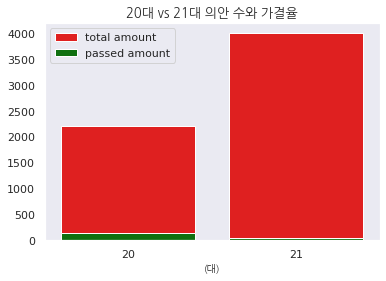

In [40]:
fig = plt.figure()
g1 = sns.barplot(data=df, x = 'AGE', y = 'count', color = 'red', label = 'total amount')
g1.set_ylabel('')
g2 = sns.barplot(data=df, x = 'AGE', y ='pass', color = 'green', label = 'passed amount')
g2.set_ylabel('')

plt.title('20대 vs 21대 의안 수와 가결율', fontproperties = font_title)
plt.xlabel('(대)', fontproperties = font_ticks)
plt.legend()

아쉽게도 21대 국회는 20대에 비해 조금 더 비효율적인 양상을 보입니다.
* 20대 동기와 비교했을 때, 21대 국회는 의안 수가 두 배 가량 더 많습니다.
* 기준으로 잡은 기간인 4개월은 심사에 충분하지 않은 기간이긴 하지만, 분석 결과를 보았을 때 21대의 가결 의안이이 20대에 비해 낮습니다.

## 3.2. 21대 국회의 방향성
의안과 가결된 법안에 대한 워드 클라우드를 통해, 21대 국회가 어떤 방향으로 나아가고자 하는지 파악해 보겠습니다.

In [41]:
suggest_21 = ','.join(suggest[suggest.AGE == 21].BILL_NAME)
passed_21 = ','.join(suggest[(suggest.AGE==21)&((suggest.PROC_RESULT=='원안가결')|(suggest.PROC_RESULT=='수정가결'))].BILL_NAME)

In [42]:
stopwords = set(STOPWORDS) 
stopwords.add('에')
stopwords.add('관한')
stopwords.add('일부개정법률안')
stopwords.add('법')
stopwords.add('대한')
stopwords.add(',')
stopwords.add('법률')
stopwords.add('법률안')
stopwords.add('등')
stopwords.add('및')
stopwords.add('등에')
stopwords.add('지원에')
stopwords.add('관리에')
stopwords.add('운영에')
stopwords.add('처리에')
stopwords.add('특별법')
stopwords.add('특별조치법')
stopwords.add('특례법')

wc_suggest = WordCloud(background_color='white',
                font_path = font_path,
                width=600,
                height=400,
                stopwords=stopwords).generate(suggest_21)
wc_passed = WordCloud(background_color='white',
                font_path = font_path,
                width=600,
                height=400,
                stopwords=stopwords).generate(passed_21)

Text(0.5, 1.0, '21대 국회 가결 의안')

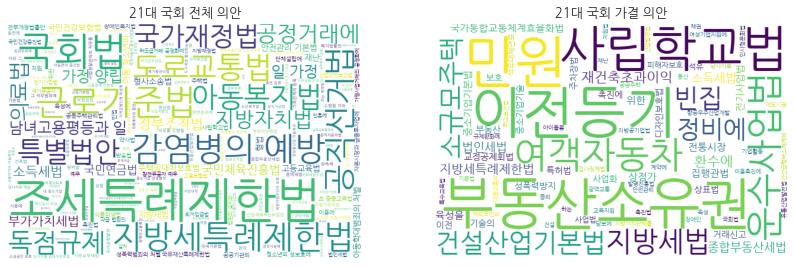

In [43]:
fig = plt.figure(figsize = (14,12))

plt.subplot(1,2,1)
plt.imshow(wc_suggest)
plt.xticks([])
plt.yticks([])
plt.title('21대 국회 전체 의안', fontproperties = font_title)

plt.subplot(1,2,2)
plt.imshow(wc_passed)
plt.xticks([])
plt.yticks([])
plt.title('21대 국회 가결 의안', fontproperties = font_title)

* 21대 국회 전체 의안 중 '감염병', '조세', '국회','도로교통'에 관련된 것의 비중이 높은 것으로 보입니다.
* 그 중, 가결된 것은 '부동산', '운수사업', '사립학교' 등에 대한 비중이 높습니다.